In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime
import multiprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, KFold, GridSearchCV, ParameterGrid
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz, export_text
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

random_state=100

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [2]:
data = pd.read_csv(r'C:\Users\pepel\OneDrive\Escritorio\CUNEF\PROGRA\pfinal\airbnb-listings-extract.csv', sep=';', encoding = "utf8", engine="python")
data.head()

ID                            Listing Url       Scrape ID  \
0  11210388  https://www.airbnb.com/rooms/11210388  20170306202425   
1  17471131  https://www.airbnb.com/rooms/17471131  20170407214050   
2  17584891  https://www.airbnb.com/rooms/17584891  20170407214050   
3   5398030   https://www.airbnb.com/rooms/5398030  20170407214050   
4  18104606  https://www.airbnb.com/rooms/18104606  20170407214050   

  Last Scraped                                 Name  \
0   2017-03-07       The Loft-Full Bath-Deck w/View   
1   2017-04-08           Claris I, Friendly Rentals   
2   2017-04-08  Style Terrace Red, Friendly Rentals   
3   2017-04-08    Picasso Suite 1.4 Paseo de Gracia   
4   2017-04-08       Smart City Centre Apartment II   

                                             Summary  \
0  Loft in the Hill country 12-15 minutes directl...   
1  This apartment has: 1 double bed, 1 double sof...   
2  This apartment has: 1 double bed, 1 double sof...   
3  Live like a local in Barcelona's most chic dis...   
4  Unique apartment in vibrant neighborhoods, car...   

                                               Space  \
0  This loft has a spectacular view of the hills ...   
1  This apartment has: 1 double bed, 1 double sof...   
2  This apartment has: 1 double bed, 1 double sof...   
3  You wake up to the sun rising over Barcelona's...   
4  License: HUTB-005313 Charming apartment, locat...   

                                         Description Experiences Offered  \
0  Loft in the Hill country 12-15 minutes directl...                none   
1  This apartment has: 1 double bed, 1 double sof...                none   
2  This apartment has: 1 double bed, 1 double sof...                none   
3  Live like a local in Barcelona's most chic dis...                none   
4  Unique apartment in vibrant neighborhoods, car...                none   

                               Neighborhood Overview  \
0  This neighborhood is located in the hills west...   
1  Plaza   Cataluña Catalonia Square is the large...   
2  Plaza   Cataluña Catalonia Square is the large...   
3  We're right in the heart of the chic L'Eixampl...   
4                                                NaN   

                                               Notes  \
0  The loft is located on a gated property.  Ther...   
1                                                NaN   
2                                                NaN   
3                          Local permit: HUTB-006794   
4                                                NaN   

                                             Transit  \
0  There is no public transportation from this lo...   
1  Ideal to discover the city either on foot or b...   
2  Ideal to discover the city either on foot or b...   
3  Whatever it is you came to see in Barcelona, I...   
4                                                NaN   

                                              Access  \
0  The loft is entirely private to the guest as i...   
1  Travellers will have access to the entire apar...   
2  Travellers will have access to the entire apar...   
3  This property features keyless entry, making i...   
4                                                NaN   

                                         Interaction  \
0  My wife and I live on the property so we would...   
1  We will be more than happy to help you with an...   
2  We will be more than happy to help you with an...   
3  I'm an Aussie who's lived in Barcelona for alm...   
4                                                NaN   

                                         House Rules  \
0  The loft is entirely private but is adjacent t...   
1  CHECK-IN Week Days: The check-in and key colle...   
2  CHECK-IN Week Days: The check-in and key colle...   
3  Welcome to Barcelona! This will be your home n...   
4                                                NaN   

                                       Thumbnail Url  \
0  https://a0.muscache.com/im/pictures/c351a9b5-

In [3]:
data.shape

(14780, 89)

### Análisis Descriptivo

En primer lugar, quitaremos los espacios de las variables, ya que puede ser un problema a la hora de llamar a las mismas posteriormente

In [4]:
data.columns = data.columns.str.replace(' ', '_')

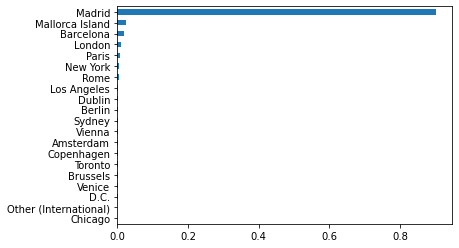

In [5]:
data['Market'].value_counts(ascending=True,normalize=True).tail(20).plot.barh()
plt.show()

Lo primero que hacemos es un pequeño estudio sobre la procedencia de las casas.
Por lo que podemos observar, la aplastante mayoría de reservas son en la ciudad de Madrid, es por ello que considero interesante quedarnos sólo con esta ciudad, ya que podremos centrarnos en las características de los pisos e incluso estudiar cómo dependiendo de la zona de Madrid cambian los precios.
Quitamos la variable Market y no la City, ya que la City en muchos casos habla de zonas y no de ciudades, cómo por ejemplo Pozuelo de Alarcón o Getafe, que podrían aportarnos información sobre la variable objetivo.

In [6]:
data = data.loc[data.Market == 'Madrid']
data = data.drop(columns ='Market')

También resulta conveniente cambiar el formato de las fechas, que son las variables Host_Since, Calendar_last_Scraped, First_Review y Last_Review.
Cambiaremos la fecha por el número de días que hay desde esa fecha concreta a la actualidad (5/7/2022)

In [7]:
data['First_Review'] = (pd.to_datetime("2022-07-05") - pd.to_datetime(data['First_Review'])).dt.days
data['Last_Review'] = (pd.to_datetime("2022-07-05") - pd.to_datetime(data['Last_Review'])).dt.days
data['Calendar_last_Scraped'] = (pd.to_datetime("2022-07-05") - pd.to_datetime(data['Calendar_last_Scraped'])).dt.days
data['Host_Since'] = (pd.to_datetime("2022-07-05") - pd.to_datetime(data['Host_Since'])).dt.days

Ahora, vamos a analizar los datos missing, viendo cómo tratarlos según el número de NA's que tenga cada variable.

In [8]:
pd.set_option('display.max_rows', None)

pd.DataFrame({'Missing': data.isna().sum(),
              'Missing_percentage': round(data.isnull().sum() * 100 / len(data),2),
              'Data_type': data.dtypes}).sort_values(by = "Missing_percentage", ascending=False)

Missing  Missing_percentage Data_type
Jurisdiction_Names                13274              100.00    object
Has_Availability                  13274              100.00    object
Host_Acceptance_Rate              13274              100.00    object
License                           13025               98.12    object
Square_Feet                       12752               96.07   float64
Monthly_Price                      9951               74.97   float64
Weekly_Price                       9909               74.65   float64
Notes                              8278               62.36    object
Security_Deposit                   7642               57.57   float64
Interaction                        5798               43.68    object
Access                             5749               43.31    object
Cleaning_Fee                       5442               41.00   float64
Transit                            5063               38.14    object
Host_About                         5021               37.83    object
Neighborhood_Overview              4989               37.58    object
House_Rules                        4630               34.88    object
Neighbourhood                      4563               34.38    object
Space                              3629               27.34    object
Host_Neighbourhood                 3352               25.25    object
Review_Scores_Location             2912               21.94   float64
Review_Scores_Value                2912               21.94   float64
Review_Scores_Checkin              2910               21.92   float64
Review_Scores_Accuracy             2901               21.85   float64
Review_Scores_Communication        2895               21.81   float64
Review_Scores_Cleanliness          2895               21.81   float64
Review_Scores_Rating               2883               21.72   float64
Last_Review                        2763               20.82   float64
Reviews_per_Month                  2762               20.81   float64
First_Review                       2762               20.81   float64
Thumbnail_Url                      2486               18.73    object
Medium_Url                         2486               18.73    object
XL_Picture_Url                     2486               18.73    object
Host_Response_Time                 1706               12.85    object
Host_Response_Rate                 1706               12.85   float64
Summary                             489                3.68    object
Zipcode                             444                3.34    object
Amenities                           162                1.22    object
Bathrooms                            50                0.38   float64
Beds                                 49                0.37   float64
State                                47                0.35    object
Host_Location                        42                0.32    object
Bedrooms                             23                0.17   float64
Picture_Url                          19                0.14    object
Price                                 9                0.07   float64
Host_Verifications                    6                0.05    object
City                                  6                0.05    object
Description                           6                0.05    object
Host_Total_Listings_Count             3                0.02   float64
Host_Listings_Count                   3                0.02   float64
Host_Thumbnail_Url                    3                0.02    object
Host_Since                            3                0.02   float64
Host_Name                             3                0.02    object
Host_Picture_Url                      3                0.02    object
Country                               1                0.01    object
Neighbourhood_Group_Cleansed          1                0.01    object
Calendar_last_Scraped                 0                0.00     int64
Availability_365                      0   

### Eliminar variables con muchos NAs o inútiles

En primer lugar, se aprecia una clara distinción entre el porcentaje de Nas en Square_Feet (96%) y Monthly_Price (74%), por lo que ahí estableceremos nuestro punto de corte a la hora de quitar las columnas con un número tan alto de NAs. (Quitaremos Jurisdiction_Names, Has_Availability, License, Square_Feet y Host_Acceptance_Rate)

También quitaremos las columnas que no aporten información, ya sea por que tengan un valor único para cada observación o el mismo para todas

Eliminaremos Geolocation, pues es la suma de Longitude y Latitude, además de algunas variables que aportan poco o nada al modelo, o están duplicadas.

También quitaremos aquellas variables que consisten en una descripción única para cada observación, cómo Summary, Space, Description, Neighborhood_Overview, Notes, Interaction, House Rules, Urls, etc... Ya que no podemos hacer nada con ellas.


In [9]:
data = data.drop(columns = ['ID', 'Listing_Url', 'Geolocation','Scrape_ID', 'Name' , 'Experiences_Offered', 'Host_Acceptance_Rate', 
                            'Square_Feet', 'License', 'Jurisdiction_Names', 'Has_Availability', 'Last_Scraped', 'Host_Name','Neighbourhood', 
                            'Neighbourhood_Group_Cleansed', 'State', 'Country_Code', 'Country', "Zipcode", 'Calculated_host_listings_count',
                            'Space', 'Description' , 'Neighborhood_Overview', 'Notes', 'Transit', 'Access', 'Interaction' , 'House_Rules',
                            'Thumbnail_Url', 'Medium_Url', 'Picture_Url', 'XL_Picture_Url','Host_URL', 'Host_Location', 
                            'Host_About', 'Host_Thumbnail_Url', 'Host_Picture_Url', 'Street' , 'Features', 'Amenities', 'Host_Verifications','Summary'])

In [10]:
data.head()

Host_ID  Host_Since  Host_Response_Time  Host_Response_Rate  \
40  25709853      2737.0      within an hour                84.0   
41  25465787      2742.0  within a few hours               100.0   
42  67750039      2269.0      within an hour               100.0   
43   3511249      3587.0      within an hour               100.0   
44  10812091      3114.0      within an hour               100.0   

   Host_Neighbourhood  Host_Listings_Count  Host_Total_Listings_Count  \
40                NaN                  3.0                        3.0   
41          Recoletos                  1.0                        1.0   
42          Recoletos                  2.0                        2.0   
43          Recoletos                  8.0                        8.0   
44          Recoletos                  2.0                        2.0   

   Neighbourhood_Cleansed    City Smart_Location   Latitude  Longitude  \
40             Niño Jesús  Madrid  Madrid, Spain  40.406953  -3.670894   
41              Recoletos  Madrid  Madrid, Spain  40.425904  -3.681647   
42              Recoletos  Madrid  Madrid, Spain  40.428352  -3.687155   
43              Recoletos  Madrid  Madrid, Spain  40.427454  -3.685763   
44              Recoletos  Madrid  Madrid, Spain  40.428671  -3.685423   

   Property_Type        Room_Type  Accommodates  Bathrooms  Bedrooms  Beds  \
40     Apartment     Private room             2        2.0       1.0   1.0   
41     Apartment  Entire home/apt             2        1.0       0.0   1.0   
42     Apartment  Entire home/apt             3        1.0       0.0   2.0   
43     Apartment     Private room             1        1.0       1.0   1.0   
44     Apartment  Entire home/apt             6        1.0       2.0   3.0   

    Bed_Type  Price  Weekly_Price  Monthly_Price  Security_Deposit  \
40  Real Bed   28.0           NaN            NaN               NaN   
41  Real Bed   58.0         371.0          981.0             100.0   
42  Real Bed   70.0           NaN            NaN             150.0   
43  Real Bed   26.0           NaN            NaN               NaN   
44  Real Bed   70.0           NaN            NaN               NaN   

    Cleaning_Fee  Guests_Included  Extra_People  Minimum_Nights  \
40           NaN                1             5               1   
41           NaN                1             0               2   
42          30.0                2            15               2   
43           NaN                1             0               7   
44          20.0                1            10               2   

    Maximum_Nights Calendar_Updated  Availability_30  Availability_60  \
40            1125      2 weeks ago                0                3   
41            1125       6 days ago                4                9   
42            1125            today                7               15   
43            1125      4 weeks ago               14               37   
44            1125      5 weeks ago                0                0   

    Availability_90  Availability_365  Calendar_last_Scraped  \
40               12               240                   1915   
41                9                15                   1914   
42               32               292                   1914   
43               59               334                   1914   
44                0                52                   1914   

    Number_of_Reviews  First_Review  Last_Review  Review_Scores_Rating  \
40                171        2578.0       1931.0                  87.0   
41                 52        2682.0       1969.0                  96.0   
42                 36        2242.0       1920.0                  87.0   
43                 15        2707.0       2068.0                  95.0   
44                  0           NaN          NaN                   NaN   

    Review_Scores_Accuracy  Review_Scores_Cleanliness  Review_Scores_Checkin  \
40                     9.0                        9.0                 

Ahora vemos un dataset bastante más limpio, aunque aún nos quedan los Nas por tratar

Ahora, debemos centrarnos en las variables que contienen NAs signicativos, pero que hemos decidido no borrar, en cuyo caso haremos lo siguiente:

    -Hay 3 excepciones, que son Extra_People, Cleaning_Fee y Security_Deposit, que son 3 variables para las cuales tiene sentido asumir que si no hay datos, es porque el arrendatario ha decidido no imponer esa tasa. Por tanto, sustituiremos los NAs por 0.

    -También tenemos un problema con Monthly_Price y Weekly_Price, ya que hay muchos NAs. En este caso, esto se debe a que esos precios se correponden con ofertas que el propio host hace para incentivar a la gente a estar más tiempo en su piso, ya que, al tener unos costes fijos por cliente, si estás más tiempo en su casa, estos se reducen. Por tanto, tiene sentido sustituir los NAs en esta variable por el precio diario multiplicado por 7 o 30, según cuál de las 2 sea, lo que correspondería a no tener oferta.
        
    -Los NAs de las variables de Host_Response_Time y Host_Response_Rate los sustituiremos por un número alto y extremo, de tal forma que podamos aislarlo más adelante en nuestro estudio, lo mismo haremos 
    
    -En el resto de variables con NAs, sustituiremos la variable por la media, incluyendo nuestra variable objetivo price, aunque la incidencia de missing values en ella es muy pequeña (0,07%).

In [11]:
data['Cleaning_Fee'] = data['Cleaning_Fee'].fillna(0)
data['Extra_People'] = data['Extra_People'].fillna(0)
data['Security_Deposit'] = data['Security_Deposit'].fillna(0)

In [12]:
data['Host_Response_Time'] = data['Host_Response_Time'].fillna(99)
data['Host_Response_Rate'] = data['Host_Response_Rate'].fillna(0)

data['Host_Listings_Count'] = data['Host_Listings_Count'].fillna(value = data['Host_Listings_Count'].mean())
data['Bathrooms'] = data['Bathrooms'].fillna(value = data['Bathrooms'].mean())
data['Bedrooms'] = data['Bedrooms'].fillna(value = data['Bedrooms'].mean())
data['Beds'] = data['Beds'].fillna(value = data['Beds'].mean())
data['Price'] = data['Price'].fillna(value = data['Price'].mean())
data['Review_Scores_Rating'] = data['Review_Scores_Rating'].fillna(value = data['Review_Scores_Rating'].mean())
data['Review_Scores_Accuracy'] = data['Review_Scores_Accuracy'].fillna(value = data['Review_Scores_Accuracy'].mean())
data['Review_Scores_Cleanliness'] = data['Review_Scores_Cleanliness'].fillna(value = data['Review_Scores_Cleanliness'].mean())
data['Review_Scores_Checkin'] = data['Review_Scores_Checkin'].fillna(value = data['Review_Scores_Checkin'].mean())
data['Review_Scores_Communication'] = data['Review_Scores_Communication'].fillna(value = data['Review_Scores_Communication'].mean())
data['Review_Scores_Location'] = data['Review_Scores_Location'].fillna(value = data['Review_Scores_Location'].mean())
data['Review_Scores_Value'] = data['Review_Scores_Value'].fillna(value = data['Review_Scores_Value'].mean())
data['Reviews_per_Month'] = data['Reviews_per_Month'].fillna(value = data['Reviews_per_Month'].mean())
data['First_Review'] = data['First_Review'].fillna(value = data['First_Review'].mean())
data['Last_Review'] = data['Last_Review'].fillna(value = data['Last_Review'].mean())

data['Host_Neighbourhood'] = data['Host_Neighbourhood'].fillna('Sin Barrio')
data['City'] = data['City'].fillna('Sin Ciudad')

data = data[data['Host_Total_Listings_Count'].notna()]



In [13]:
data['Weekly_Price'] = data['Weekly_Price'].fillna(data['Price']*7)
data['Monthly_Price'] = data['Monthly_Price'].fillna(data['Price']*30)

Ahora, nos centraremos en nuestra variable objetivo, que es el Precio

In [14]:
nas = [var for var in data.columns if data[var].isnull().sum() > 0]
nas

[]

Podemos comprobar con esta sencilla función, que nuestros datos no presentan ningún NA, por lo que podemos pasar al siguiente paso, que es transformar los datos en formatos que nos interesen más para la realización del trabajo.
Ya hemos hecho algunas transformaciones anteriormente, por lo que realizaremos las transformaciones que nos queden.

En primer lugar, convertiremos Host_response en una variable dummie, ya que nos ayudará a poder trabajar con ella de una manera más efectiva.

In [15]:
data["Host_Response_Time"] = data.Host_Response_Time.astype('category')

In [16]:
dummies=pd.get_dummies(data["Host_Response_Time"])
data1 = data.drop('Host_Response_Time',axis = 1)
data = data1.join(dummies)

In [17]:
data.head()

Host_ID  Host_Since  Host_Response_Rate Host_Neighbourhood  \
40  25709853      2737.0                84.0         Sin Barrio   
41  25465787      2742.0               100.0          Recoletos   
42  67750039      2269.0               100.0          Recoletos   
43   3511249      3587.0               100.0          Recoletos   
44  10812091      3114.0               100.0          Recoletos   

    Host_Listings_Count  Host_Total_Listings_Count Neighbourhood_Cleansed  \
40                  3.0                        3.0             Niño Jesús   
41                  1.0                        1.0              Recoletos   
42                  2.0                        2.0              Recoletos   
43                  8.0                        8.0              Recoletos   
44                  2.0                        2.0              Recoletos   

      City Smart_Location   Latitude  Longitude Property_Type  \
40  Madrid  Madrid, Spain  40.406953  -3.670894     Apartment   
41  Madrid  Madrid, Spain  40.425904  -3.681647     Apartment   
42  Madrid  Madrid, Spain  40.428352  -3.687155     Apartment   
43  Madrid  Madrid, Spain  40.427454  -3.685763     Apartment   
44  Madrid  Madrid, Spain  40.428671  -3.685423     Apartment   

          Room_Type  Accommodates  Bathrooms  Bedrooms  Beds  Bed_Type  Price  \
40     Private room             2        2.0       1.0   1.0  Real Bed   28.0   
41  Entire home/apt             2        1.0       0.0   1.0  Real Bed   58.0   
42  Entire home/apt             3        1.0       0.0   2.0  Real Bed   70.0   
43     Private room             1        1.0       1.0   1.0  Real Bed   26.0   
44  Entire home/apt             6        1.0       2.0   3.0  Real Bed   70.0   

    Weekly_Price  Monthly_Price  Security_Deposit  Cleaning_Fee  \
40         196.0          840.0               0.0           0.0   
41         371.0          981.0             100.0           0.0   
42         490.0         2100.0             150.0          30.0   
43         182.0          780.0               0.0           0.0   
44         490.0         2100.0               0.0          20.0   

    Guests_Included  Extra_People  Minimum_Nights  Maximum_Nights  \
40                1             5               1            1125   
41                1             0               2            1125   
42                2            15               2            1125   
43                1             0               7            1125   
44                1            10               2            1125   

   Calendar_Updated  Availability_30  Availability_60  Availability_90  \
40      2 weeks ago                0                3               12   
41       6 days ago                4                9                9   
42            today                7               15               32   
43      4 weeks ago               14               37               59   
44      5 weeks ago                0                0                0   

    Availability_365  Calendar_last_Scraped  Number_of_Reviews  First_Review  \
40               240                   1915                171   2578.000000   
41                15                   1914                 52   2682.000000   
42               292                   1914                 36   2242.000000   
43               334                   1914                 15   2707.000000   
44                52                   1914                  0   2419.601408   

    Last_Review  Review_Scores_Rating  Review_Scores_Accuracy  \
40  1931.000000             87.000000                9.000000   
41  1969.000000             96.000000               10.000000   
42  1920.000000             87.000000                9.000000   
43  2068.000000             95.000000               10.000000   
44  2014.132242             91.616688                9.407982   

    Review_Scores_Cleanliness  Review_Scores_Checkin  \
40                   9.000000               9.000000   
41            

Podemos observar que, efectivamente, se han creado correctamente los dummies, y el join realizado no ha dado ningún problema. Esto hará posible trabajar mucho más eficientemente con la variable.

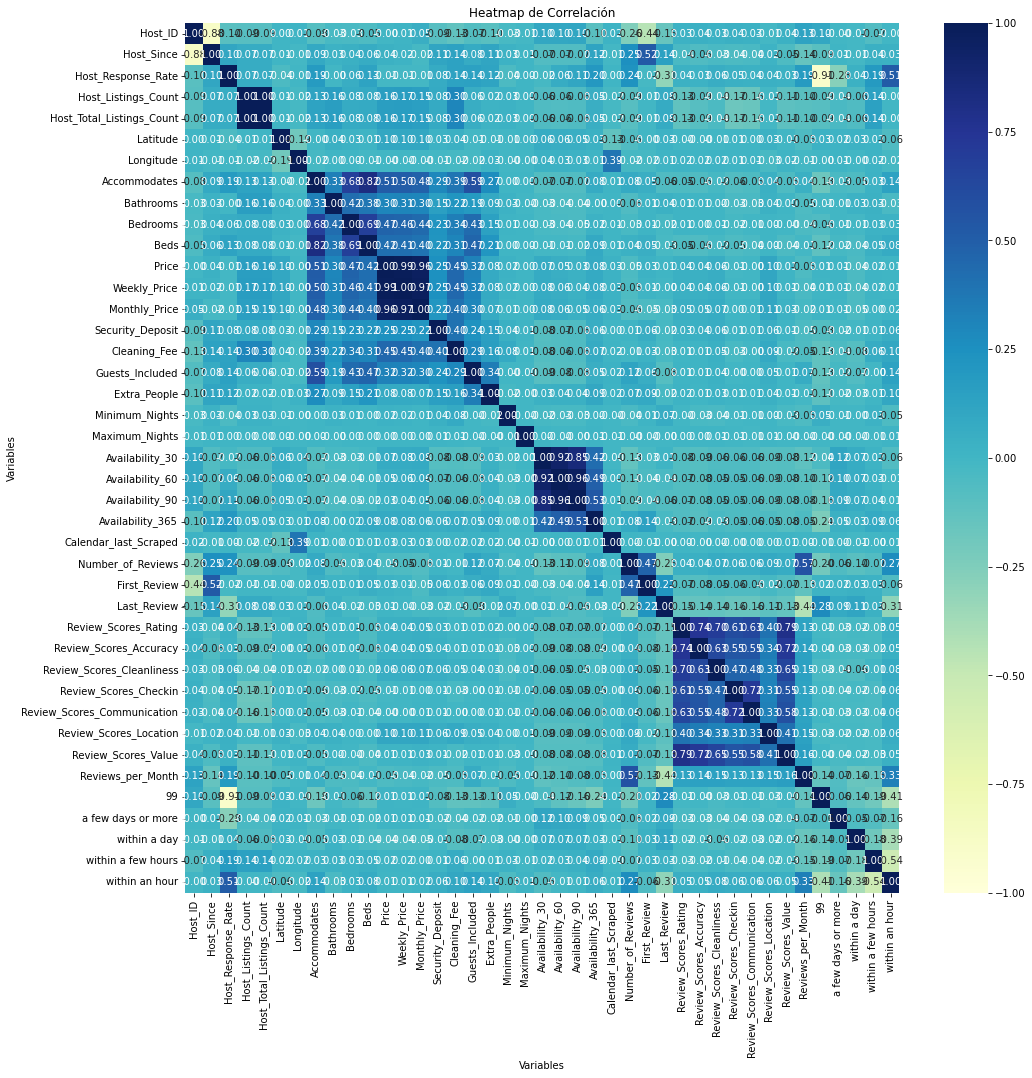

In [18]:
corrmat = data.corr()
plt.figure(figsize=(16,16))
ax=sns.heatmap(corrmat, cmap='YlGnBu',
               annot=True,
              vmin=-1,
               vmax=1,
               center=0,fmt='.2f') 
ax.set(title='Heatmap de Correlación',
      ylabel='Variables',
      xlabel='Variables')
plt.show()

En el mapa de correlaciones vemos cosas muy interesantes, como las siguientes:

    - Alta correlación negativa entre Host ID y Host since, pues la gente que más tiempo lleva siendo Host, tiene un alto número de Host since, ya que hace muchos días que es Host, y un bajo Host ID, ya que le asignaron el ID de los primeros y por eso es un número bajo.
    
    - Correlación casi perecta entre Price, Weekly price y Monthly price, ya que sustituimos los NAs en los dos últimos por el Price que les correspondería, lo que significa que, excepto los que tenían ofertas en Weekly o Monthly price, estoas tres variables son combinaciones lineales entre si.
    
    - LAs reviews en general tienen bastante correlación, ya que en general si tienes una review de un tipo buena, el resto de tipos de reviews lo son también.
    
    - Alta correlación entre las distintas disponibilidades, especificamente esta correlación viene dada por pisos con una baja disponibilidad en todo el año, ya que tendrían datos muy parecidos en Availability_30, Availability_60 y Availability_90

<AxesSubplot:>

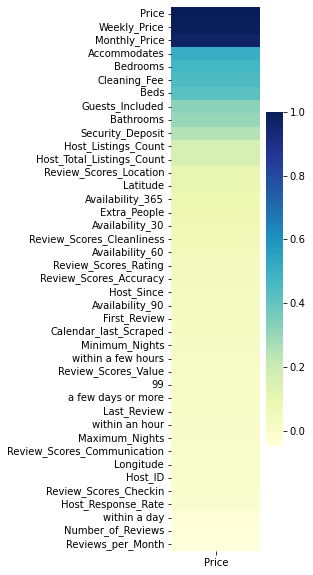

In [19]:
corr = data.corr().loc[['Price']].sort_values('Price',ascending=False)
corr = corr.T.sort_values('Price',ascending=False)
plt.subplots(figsize=(2,10))
sns.heatmap(corr, cmap="YlGnBu")

Aquí llama especialmente la atención que el número de bedrooms es lo que más marca el precio, así cómo el número de camas o los guests que pueden acoger en un determinado alojamiento.
Esto tiene bastante sentido y se refleja en la realidad.

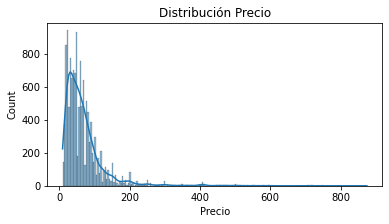

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.histplot(data=data, x='Price', kde=True,ax=ax)
ax.set_title("Distribución Precio")
ax.set_xlabel('Precio');

En este gráfico podemos observar que la mayoría de los precios se encuentran en el tramo de 30-100€, habiendo precios de hasta 900€. A continuación observaremos cómo esto depende de la zona geográfica de cada alojamiento.

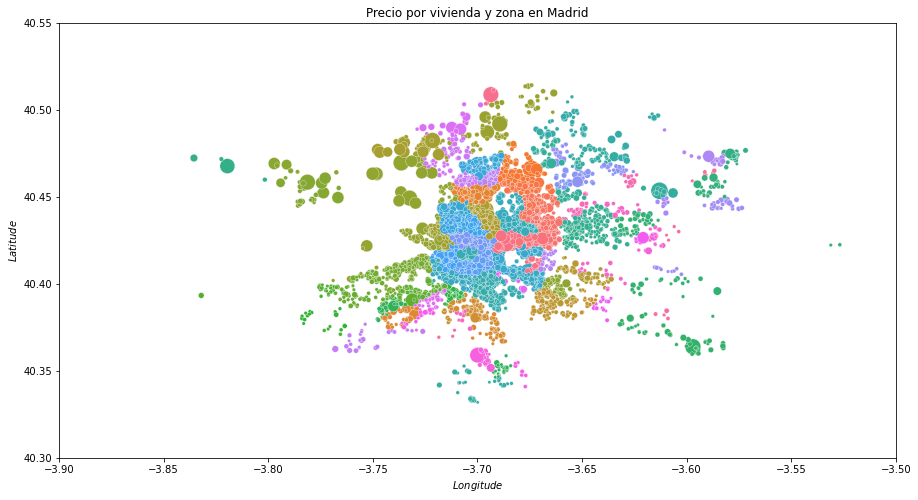

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))
with sns.plotting_context("notebook", font_scale=1.5):
    sns.scatterplot(x='Longitude',
                    y='Latitude',
                    size='Price',
                    hue = 'Neighbourhood_Cleansed',
                    palette=sns.color_palette("husl", len(pd.unique(data['Neighbourhood_Cleansed']))),
                    sizes=(10, 300), 
                    data=data, 
                    ax=ax,
                    legend = False)

ax.set_xlabel(r'$Longitude$')
ax.set_ylabel(r'$Latitude$')
ax.set(ylim=(40.3,40.55), xlim=(-3.9,-3.5), title='Precio por vivienda y zona en Madrid')

plt.show()

Este gráfico es muy visual, y nos muestra cómo los precios oscilan según la zona de Madrid en la que nos encontramos, siendo el precio el tamaño del círculo.
En primer lugar, vemos cómo los precios más altos se corresponden al noroeste de Madrid, incluso más que en el centro de la ciudad. Esto se puede explicar de forma sencilla, ya que a las aueras de Madrid las casas son más grandes, por lo que el precio es superior a loq ue puede serlo un piso en el centro.
De todas formas, observamos que en el centro los precios también son altos, especialmente si los comparamos con la parte sur de Madrid, que en este caso es la más barata de toda la ciudad.

### Principal Component Analisis

En el siguiuente paso realizaremos un PCA, que nos servirá en primer lugar para la detección de outliers, y en segundo lugar, y si fuese necesario, para reducir el número de variables.

En primer lugar, seleccionaremos los datso númericos del dataframe, y tras eso, procederemos a su normalización, aplicando sencillamente la fórmula para normalizar, de forma manual, de forma que el PCA no de mayor peso a las variables que tienen una escala mayor.
Esta normalización resultará en que las variables tendrán madia cero y desviación típica 1.

In [22]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

data_num = data.select_dtypes(include=numerics)

In [23]:
data_num_norm = (data_num - data_num.mean())/data_num.std()
data_num_norm.head(5)

Host_ID  Host_Since  Host_Response_Rate  Host_Listings_Count  \
40 -0.343820   -0.136863            0.039524            -0.241774   
41 -0.350860   -0.128327            0.499456            -0.313693   
42  0.868743   -0.935836            0.499456            -0.277734   
43 -0.984093    1.314262            0.499456            -0.061977   
44 -0.773515    0.506754            0.499456            -0.277734   

    Host_Total_Listings_Count  Latitude  Longitude  Accommodates  Bathrooms  \
40                  -0.241774 -0.643466   0.423986     -0.594509   1.250772   
41                  -0.313693  0.244741   0.247844     -0.594509  -0.422027   
42                  -0.277734  0.359473   0.157631     -0.092745  -0.422027   
43                  -0.061977  0.317411   0.180427     -1.096272  -0.422027   
44                  -0.277734  0.374423   0.186001      1.412544  -0.422027   

    Bedrooms      Beds     Price  Weekly_Price  Monthly_Price  \
40 -0.359299 -0.650016 -0.638418     -0.619060      -0.564976   
41 -1.572966 -0.650016 -0.152732     -0.211091      -0.487353   
42 -1.572966  0.012119  0.041542      0.066328       0.128673   
43 -0.359299 -0.650016 -0.670797     -0.651698      -0.598007   
44  0.854367  0.674255  0.041542      0.066328       0.128673   

    Security_Deposit  Cleaning_Fee  Guests_Included  Extra_People  \
40         -0.675832     -0.708107        -0.526855     -0.222910   
41          0.192733     -0.708107        -0.526855     -0.686803   
42          0.627016      0.507773         0.390114      0.704875   
43         -0.675832     -0.708107        -0.526855     -0.686803   
44         -0.675832      0.102479        -0.526855      0.240982   

    Minimum_Nights  Maximum_Nights  Availability_30  Availability_60  \
40       -0.156526         0.01853        -0.964593        -1.024470   
41       -0.078750         0.01853        -0.528041        -0.718343   
42       -0.078750         0.01853        -0.200628        -0.412217   
43        0.310134         0.01853         0.563338         0.710247   
44       -0.078750         0.01853        -0.964593        -1.177533   

    Availability_90  Availability_365  Calendar_last_Scraped  \
40        -0.961509          0.268155               1.476485   
41        -1.063419         -1.504143              -0.560358   
42        -0.282109          0.677753              -0.560358   
43         0.635081          1.008582              -0.560358   
44        -1.369149         -1.212699              -0.560358   

    Number_of_Reviews  First_Review   Last_Review  Review_Scores_Rating  \
40           3.846328  4.171036e-01 -5.657669e-01         -5.804839e-01   
41           0.752095  6.909619e-01 -3.071531e-01          5.511403e-01   
42           0.336064 -4.676695e-01 -6.406288e-01         -5.804839e-01   
43          -0.209977  7.567932e-01  3.666038e-01          4.254042e-01   
44          -0.600006 -2.167411e-13  5.338599e-13         -4.127546e-13   

    Review_Scores_Accuracy  Review_Scores_Cleanliness  Review_Scores_Checkin  \
40           -4.989766e-01              -3.713274e-01          -8.935718e-01   
41            7.240585e-01               7.652125e-01           5.413489e-01   
42           -4.989766e-01              -3.713274e-01           5.413489e-01   
43            7.240585e-01              -3.713274e-01           5.413489e-01   
44           -8.081874e-13               5.329897e-13          -5.837052e-13   

    Review_Scores_Communication  Review_Scores_Location  Review_Scores_Value  \
40                -9.614877e-01           -8.010745e-01        -2.513673e-01   
41                 5.301836e-01            6.748739e-01         9.341893e-01   
42                 5.301836e-01            6.748739e-01        -2.513673e-01   
43                 5.301836e-01            6.748739e-01        -2.513673e-01   
44                 6.279885e-13            7.419725e-13        -2.253390e-13   

    Reviews_per_Month  
40       3.440364e+00  
41       6.284939e-02  
42    

Tras realizar la normalización, procederemos con el PCA, que nos permitirá simplificar la información de nuestras variables en menos componentes.

En primer lugar, realizaremos un PCA con todas las variables predictoras, excluyendo Price, ya que obviamente no nos interesa tener información directamente de nuetra variable objetivo en los componentes del PCA, porque distorsionaría los resultados.
También estudiaremso la posible presencia de outliers, ya que afectarían considerablemente al modelo.

Text(0.5, 1.0, 'PCA')

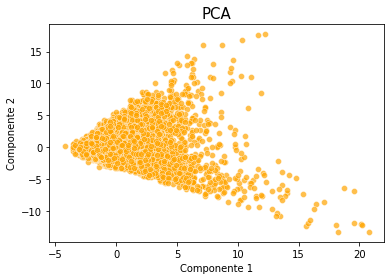

In [24]:
data_num_PCA = data_num_norm.drop(columns ='Price')

pca = PCA(n_components = 35, whiten=False, random_state=100)
data_PCA = pca.fit_transform(data_num_PCA)
sns.scatterplot(data_PCA[:,0], data_PCA[:,1],
                color='orange',alpha=0.7)

plt.xlabel("Componente 1", fontsize = 10)
plt.ylabel("Componente 2", fontsize = 10)
plt.title('PCA', fontsize = 15)

In [25]:
var = np.cumsum(pca.explained_variance_ratio_)
comps = [i for i,el in enumerate(np.cumsum(pca.explained_variance_ratio_)) if el > 0.85][0]
print(comps)

17


En este caso podemos observar como con 17 componentes podemos explicar más del 85% de la varianza, lo que es más que satisfactorio. Es por ello que vamos a realizar un nuevo PCA con estos componentes.

In [26]:
pca = PCA(n_components = comps, whiten=False, random_state=100)
data_PCA = pca.fit_transform(data_num_PCA)

In [27]:
main_variables = sorted([(abs(el),i) for i,el in enumerate(pca.components_[0])], reverse=True)
print(main_variables[:8])
[data_num_norm.columns[i] for n,i in main_variables[:8]]

[(0.3391411306603183, 27), (0.33195741362347536, 33), (0.31726399855211523, 28), (0.30570272060200504, 31), (0.3045503345371104, 30), (0.28173221099943474, 29), (0.21745951365387506, 7), (0.20448434289009465, 10)]


['Last_Review',
 'Review_Scores_Location',
 'Review_Scores_Rating',
 'Review_Scores_Checkin',
 'Review_Scores_Cleanliness',
 'Review_Scores_Accuracy',
 'Accommodates',
 'Beds']

Vemos que las variables más influyentes a la hora de explicar la mayor varianza posible son 'Last_Review', 'Review_Scores_Location', 'Review_Scores_Rating', 'Review_Scores_Checkin', 'Review_Scores_Cleanliness', 'Review_Scores_Accuracy', 'Accommodates' y 'Beds', explicando desde un 33% a un 20% de la varianza.
Llama la atención como la mayoría de ellas están bastante correlacionadas, cómo hemos podido observar en la matriz de correlaciones.

In [28]:
reverse = pca.inverse_transform(data_PCA)

data_nump = data_num_PCA.to_numpy()

error = (data_num_PCA - reverse)**2

score = np.sum(error,1)
score_mean = np.mean(score)
score_std = np.std(score)
outliers = np.where(score> score_mean + 6*score_std)

Text(0, 0.5, 'Componente 2')

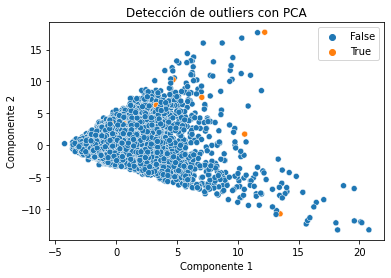

In [29]:
mark_outlier = np.where(score> score_mean + 6*score_std, True, False)
sns.scatterplot(data_PCA[:,0], data_PCA[:,1], hue=mark_outlier)
plt.title('Detección de outliers con PCA')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')

In [30]:
sumoutliers=np.sum(mark_outlier)
print(sumoutliers)

16


Hemos obtenido en el gráfico PCA 16 outlayers que podemos ver en color naranja. Estos valores atípicos podríamos quitarlos, dado que podrían distorsionar nuestra predicción de la variable objetivo.
Los hemos obtenido con la función que hemos creado en la parte sperior, siendo una función que nos devuelve el valor false en caso de detectar un outlier.
Más tarde hemos representado todos los valores que nos ha devuelto (booleans), y los hemos reprensentado en la gráfica para poder ver los outliers.

### Train /Test

In [31]:
data_num=data_num.drop(columns = ['Weekly_Price','Monthly_Price'])

In [32]:
data_train, data_test = train_test_split(data_num, test_size = 0.3, random_state = 100)

In [33]:
scaler = StandardScaler()
train_scaler = scaler.fit(data_train)

data_train_norm = pd.DataFrame(index=data_train.index,
                               columns=data_train.columns,
                               data=train_scaler.transform(data_train))

data_test_norm = pd.DataFrame(index=data_test.index,
                               columns=data_test.columns,
                               data=train_scaler.transform(data_test))

In [34]:
columns = ['pca_comp_%i' % i for i in range(comps)]
df_pca  = pd.DataFrame(data_PCA, columns=columns, index=data_num_PCA.index)

In [35]:
df_pca['Price'] = data_num['Price']

In [36]:
data_train_pca, data_test_pca = train_test_split(df_pca, test_size = 0.3, random_state = 100)

In [37]:
X_train = data_train.drop(columns='Price')
X_train_norm = data_train_norm.drop(columns='Price')
Y_train = data_train['Price']
Y_train_norm = data_train_norm['Price']

X_test = data_test.drop(columns='Price')
X_test_norm = data_test_norm.drop(columns='Price')
Y_test = data_test['Price']
Y_test_norm = data_test_norm['Price']

X_train_pca = data_train_pca.drop(columns='Price')
Y_train_pca = data_train_pca['Price']
X_test_pca = data_test_pca.drop(columns='Price')
Y_test_pca = data_test_pca['Price']

Hemos procedido a hacer el train test split al que estamos acostumbrados, creado también tanto train como test normalizado, para poder utilizarlos más adelante en caso de ser necesario.
Como se puede observar, hemos quitado 'Weekly_Price' y 'Monthly_Price', ya que al ser en su mayoría combinaciones lineales del precio, nos iban a dar problemas.

### Regresión lineal

In [38]:
lr = LinearRegression()

# Entrenamos el modelo

lr.fit(X_train_norm, Y_train)

# Información del modelo

lr.score(X_train_norm, Y_train)

print("Coeficiente de determinación:", lr.score(X_train_norm, Y_train))

Coeficiente de determinación: 0.4210696291456577


Hemos obtenido un coeficiente de determinación del 0,42, lo que implica que el 42% del precio está explicado por esta regresión.
Este resulta un porcentaje bajo para ser un modelo predictivo, por lo que es bastante probable que no acabemos utilizando este método.

### Random forest

Random Forest es un algoritmo de aprendizaje supervisado que hace crecer múltiples árboles de decisión y combina sus resultados en uno. 

Es una técnica de conjunto hecha usando modelos de decisión múltiple. La técnica de conjunto utiliza múltiples algoritmos de aprendizaje automático para obtener un mejor rendimiento predictivo. 

Random forest selecciona parámetros aleatorios para la toma de decisiones, es decir, agrega aleatoriedad adicional al modelo mientras crecen los árboles. Esto lleva a buscar la mejor característica entre un subconjunto aleatorio de características, lo que luego da como resultado un mejor modelo.

Los parámetros que destacan aquellos que detienen el crecimiento de los árboles, los que controlan el número de árboles y predictores incluidos, y los que gestionan la paralelización:

    - n_estimators: número de árboles incluidos en el modelo.

    - max_depth: profundidad máxima que pueden alcanzar los árboles.

    - min_samples_split: número mínimo de observaciones que debe de tener un nodo para que pueda dividirse.

    - min_samples_leaf: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división.

    - max_leaf_nodes: número máximo de nodos terminales que pueden tener los árboles.

    - max_features: número de predictores considerados a en cada división.

    - oob_score: Si se calcula o no el out-of-bag R^2. Por defecto es False ya que aumenta el tiempo de entrenamiento.

    - n_jobs: número de cores empleados para el entrenamiento. En random forest los árboles se ajustan de forma independiente, por lo la paralelización reduce notablemente el tiempo de entrenamiento. Con -1 se utilizan todos los cores disponibles.

    - random_state: semilla para que los resultados sean reproducibles.

In [39]:
forest = RandomForestRegressor(
            max_depth         = 3,
            random_state      = 100
          )

In [40]:
forest.fit(X_train, Y_train)

RandomForestRegressor(max_depth=3, random_state=100)

In [41]:
features = [(a,b) for a,b in zip(X_train.columns, forest.feature_importances_)]

In [42]:
features = sorted(features, key= lambda c:c[1], reverse=True)

In [43]:
fig = px.bar(x=[a for a,b in features], y=[b for a,b in features])
fig.show()

In [44]:
main_vars1ej=sorted([(abs(el), i) for i, el in enumerate(pca.components_[0])], reverse=True)
main_vars1ej[:3]

[(0.3391411306603183, 27),
 (0.33195741362347536, 33),
 (0.31726399855211523, 28)]

In [45]:
[data_num_norm.columns[i] for n, i in main_vars1ej[:3]]

['Last_Review', 'Review_Scores_Location', 'Review_Scores_Rating']

In [46]:
main_vars1ej=sorted([(abs(el), i) for i, el in enumerate(pca.components_[3])], reverse=True)
main_vars1ej[:3]

[(0.49312770307501674, 1), (0.47468662360512626, 0), (0.43243971397475633, 25)]

In [47]:
[data_num_norm.columns[i] for n, i in main_vars1ej[:3]]

['Host_Since', 'Host_ID', 'Number_of_Reviews']

In [48]:
main_vars1ej=sorted([(abs(el), i) for i, el in enumerate(pca.components_[16])], reverse=True)
main_vars1ej[:3]

[(0.5426604459666808, 30), (0.5264449179028667, 31), (0.3799022892864049, 29)]

In [49]:
[data_num_norm.columns[i] for n, i in main_vars1ej[:3]]

['Review_Scores_Cleanliness',
 'Review_Scores_Checkin',
 'Review_Scores_Accuracy']

Gracias a este modelo, podemos observar cuáles son las variables que más aportan a cada componente, y son:

    - Componente 0: 'Last_Review', 'Review_Scores_Location', 'Review_Scores_Rating'
    - Componente 3: 'Host_Since', 'Host_ID', 'Number_of_Reviews'
    - Componente 16: 'Review_Scores_Cleanliness', 'Review_Scores_Checkin', 'Review_Scores_Accuracy'

En el próximo paso,aplicaremos la validación cruzada. Es una técnica para evaluar modelos de machine learning mediante el entrenamiento de varios modelos en subconjuntos de los datos de entrada disponibles y evaluarlos con el subconjunto complementario de los datos. Por ello, pondremos diferentes hiperparametros en el estimador con varios subconjuntos, y el programa nos dirá que parametros son los que mejor estiman nuestro modelo.

Los parametros son del GridSearchCV :

    - estimator: el modelo que se ha de evaluar

    - param_grid: un diccionario en que se indicar los parámetros a evaluar como clave y el conjunto elementos como valor

    - cv: el número de conjuntos en los que se divide los datos para la validación cruzada.

In [50]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [51]:
param_grid = {'ccp_alpha':np.linspace(0, 80, 20)}

In [52]:
grid = GridSearchCV(
        estimator = RandomForestRegressor(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 100
                       ),
        param_grid = param_grid,
        cv         = 10,
        refit      = True,
        return_train_score = True
      )


In [53]:
grid.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=100),
             param_grid={'ccp_alpha': array([ 0.        ,  4.21052632,  8.42105263, 12.63157895, 16.84210526,
       21.05263158, 25.26315789, 29.47368421, 33.68421053, 37.89473684,
       42.10526316, 46.31578947, 50.52631579, 54.73684211, 58.94736842,
       63.15789474, 67.36842105, 71.57894737, 75.78947368, 80.        ])},
             return_train_score=True)

In [54]:
grid.best_params_

{'ccp_alpha': 0.0}

En este caso podemos observar cómo el 0.0 sería la mejor opción de los valores evaluados.

In [55]:
modelo_final = grid.best_estimator_

In [56]:
predicciones = forest.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = Y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 45.228336480113285


In [57]:
from sklearn.metrics import r2_score

In [58]:
print(r2_score(Y_test,predicciones))

0.47053873087222353


Podemos ver que el r2 es de 0,47, un buen resultado

In [59]:
predicciones1 = modelo_final.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = Y_test,
        y_pred  = predicciones1,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 35.936843148253196


In [60]:
print(r2_score(Y_test,predicciones1))

0.6657335296125304


In [61]:
print('\n\nforest train score %.3f, forest test score: %.3f' % (
forest.score(X_train,Y_train),
forest.score(X_test, Y_test)))



forest train score 0.491, forest test score: 0.471


In [62]:
print('\n\nforest con validacion cruzada train score %.3f, forest con validacion cruzada test score: %.3f' % (
modelo_final.score(X_train,Y_train),
modelo_final.score(X_test, Y_test)))



forest con validacion cruzada train score 0.951, forest con validacion cruzada test score: 0.666


In [64]:
rmse_forest = mean_squared_error(Y_test, forest.predict(X_test), squared=False)
rmse_forest

45.228336480113285

In [65]:
rmse_forest_validacion_cruzada = mean_squared_error(Y_test, modelo_final.predict(X_test), squared=False)
rmse_forest_validacion_cruzada

35.936843148253196

Es lógico que algún problema hay cuando el rmse es tan alto,pero no he sido capaz de identificarlo, por eso me limito a mencionar que hay algo incorrecto en el modelo.

### XGBOOST

In [66]:
import xgboost as xgb

parameters_xgbm = ({'max_depth': [10, 15, 20],
                    'n_estimators': [150, 200, 250]}) 

# Definimos el modelo

xgbm_grid = xgb.XGBRegressor()

# Modelo de Grid Search

clf_xgbm = GridSearchCV(xgbm_grid, parameters_xgbm, n_jobs=4, cv=3)

# Entrenamos el modelo de Grid Search

clf_xgbm.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,


In [67]:
clf_xgbm.best_params_

{'max_depth': 10, 'n_estimators': 150}

En este caso podemos observar cómo el número óptimo de árboles es de 150, siendo 10 la profundidad máxima de estos.

In [68]:
xgbm = xgb.XGBRegressor(max_depth = clf_xgbm.best_params_['max_depth'],
                               n_estimators= clf_xgbm.best_params_['n_estimators'])
xgbm.fit(X_train, Y_train)
xgbm.score(X_train, Y_train)

0.9997452162200452

Podemos decir con total seguridad que el modelo es muy bueno, teniendo una score de prácticamente 1. 

### PCA + XGBOOST

In [69]:
xgbm_grid_pca = xgb.XGBRegressor()
clf_xgbm_pca = GridSearchCV(xgbm_grid_pca, parameters_xgbm, n_jobs=4, cv=3)
clf_xgbm_pca.fit(X_train_pca, Y_train_pca)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,


In [70]:
clf_xgbm_pca.best_params_

{'max_depth': 10, 'n_estimators': 250}

In [71]:
xgb_pca = xgb.XGBRegressor(max_depth = clf_xgbm_pca.best_params_['max_depth'],
                               n_estimators= clf_xgbm_pca.best_params_['n_estimators'])
xgb_pca.fit(X_train_pca, Y_train_pca)
xgb_pca.score(X_train_pca, Y_train_pca)

0.9999997994280916

Si bien el XGBOOST normal ya era un gran modelo, vemos como la combinación de este con un PCA resulta en un modelo casi perfecto.

### Red neuronal

In [72]:
import tensorflow as tf

In [73]:
#with tf.device('/device:GPU:0'): #para usar el GPU de Colab
inputs = tf.keras.Input(shape=(X_train_norm.shape[1],))

x = tf.keras.layers.Dense(254, activation="relu")(inputs) #capa predictiva
x = tf.keras.layers.Dropout(0.2)(x) #capa dropout para evitar overfitting
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)

output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, output)

In [74]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.MeanSquaredError(),
             metrics=tf.keras.metrics.RootMeanSquaredError(name='rmse'))

Procedemos a aplicar el método Adam, iterando con 100 epochs para encontrar el valle, osea, el punto con el minimo valor del val_loss y val_rmse

In [75]:
model.fit(X_train_norm.to_numpy(),
          Y_train.to_numpy(), 
          epochs=100, 
          validation_data=(X_test_norm.to_numpy(),Y_test.to_numpy()),
          )

Epoch 1/100
291/291 [==============================] - 2s 3ms/step - loss: 3211.7395 - rmse: 56.6722 - val_loss: 4669.0757 - val_rmse: 68.3306
Epoch 2/100
291/291 [==============================] - 1s 3ms/step - loss: 2172.1924 - rmse: 46.6068 - val_loss: 3041.4087 - val_rmse: 55.1490
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 2070.7029 - rmse: 45.5050 - val_loss: 2117.6743 - val_rmse: 46.0182
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 1980.9714 - rmse: 44.5081 - val_loss: 2056.3730 - val_rmse: 45.3472
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 1901.8536 - rmse: 43.6102 - val_loss: 1878.2198 - val_rmse: 43.3384
Epoch 6/100
291/291 [==============================] - 1s 3ms/step - loss: 1872.8448 - rmse: 43.2764 - val_loss: 1840.2152 - val_rmse: 42.8977
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 1810.3451 - rmse: 42.5481 - val_loss: 1792.0454 - val_rmse: 42.3326

Vemos que el epoch 99 es el valle, con el minimo valor del val_loss y val_rmse

### Testeado del modelo

In [76]:
from sklearn.metrics import mean_squared_error, mean_poisson_deviance

In [77]:
rmse_linear = mean_squared_error(y_true = Y_test, y_pred = lr.predict(X_test_norm))
rmse_linear 

2294.4504587159677

In [78]:
predicted_forest = forest.predict(X_test)
rmse_forest = mean_squared_error(y_true = Y_test, y_pred = predicted_forest)
rmse_forest

2045.6024207583462

In [79]:
predicted_xgb = xgbm.predict(X_test)
rmse_xgb = mean_squared_error(y_true = Y_test, y_pred = predicted_xgb)
rmse_xgb

1259.1112587348866

In [80]:

predicted_xgb_pca = xgb_pca.predict(X_test_pca)
rmse_xgb_pca = mean_squared_error(y_true = Y_test_pca, y_pred = predicted_xgb_pca)
rmse_xgb_pca

364.2118691051744

In [81]:
predicted_data_norm = data_test_norm.copy()
predicted_data_norm['Price'] = model.predict(X_test_norm.to_numpy())
predicted_data_unorm = pd.DataFrame(index=predicted_data_norm.index, columns=predicted_data_norm.columns, data=train_scaler.inverse_transform(predicted_data_norm))
predicted_data_unorm['Predicted_Price'] = predicted_data_unorm['Price']
predicted_data_unorm['Price'] = data_test['Price']

rmse_nn = round(np.mean(100*np.sqrt((predicted_data_unorm['Price'] - predicted_data_unorm['Predicted_Price'])**2)/predicted_data_unorm['Price']),2)
rmse_nn

125/125 [==============================] - 0s 1ms/step


6906.72

### Conclusión

Tras ver todos los modelos, está claro que el modelo de regresión lineal es el que peor desempeño ha tenido de todos ellos, es por ello que sería el último modelo que utilizaría, y el primero en ser descartado.

Auque la red neuronal ha sido bastante precisa, tampoco ha sido la que mejor desempeño ha tenido, aunque quizás haya sido más por la fortaleza de los otros modelos que por un mal desempeño propio.

El XGBOOST y el Random Forest han tenido un desempeño excelente, con un bajísimo error cuadrático medio, aunque sin duda el XGBOOST resulta el ganador, ya que explica la variable objetivo como ningún otro, especialmente cuando se combina con el PCA